**Objective:**

The California housing dataset provides median house prices for California districts (block groups) from a US census.

Our goal here will be to build data preprocessing pipeline and a ML model to predict median house prices of a block group using the following attributes:
 - MedInc : median income in block group
 - HouseAge : median house age in block group
 - AveRooms : average number of rooms per household
 - AveBedrms : average number of bedrooms per household
 - Population : block group population
 - AveOccup : average number of household members
 - Latitude : block group latitude
 - Longitude : block group longitude.

Let's load essential packages and inform ourselves of their version in use:

In [1]:
print('Python Version : 3.9.18')

# for data manipulation
import pandas as pd
print('Pandas Version : ', pd.__version__)

# for data visualization
import matplotlib.pyplot as plt 
import matplotlib as mpl
print('Matplotlib Version : ', mpl.__version__)

# for machine learning
import sklearn as skl
print('SciKit-Learn Version : ', skl.__version__)

Python Version : 3.9.18
Pandas Version :  2.0.3
Matplotlib Version :  3.7.2
SciKit-Learn Version :  1.3.0


**Task**: Obtain dataset.

**Strategy**: We load the data using SciKit-Learn datasets and print its description.

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.feature_names, housing.target_names)

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] ['MedHouseVal']


In [3]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

**Task**: To check out-of-sample model performance, we would need to hold out some data for predicting prices of housing once we have the final model.

**Strategy:** We will split the dataset into training and test sets and put aside the test data to not be seen at all until we want to test our final model on it.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.25, random_state=42)

**Task**: The data may need preprocessing before a regression model can be trained on it.

**Strategy**: We will create a Pandas DataFrame from X_train so we can manipulate and visualize it more conveniently.

In [5]:
df = pd.DataFrame(X_train, columns=housing.feature_names)
df['MedHouseVal'] = y_train
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.2143,37.0,5.288235,0.973529,860.0,2.529412,33.81,-118.12,2.285
1,5.3468,42.0,6.364322,1.087940,957.0,2.404523,37.16,-121.98,2.799
2,3.9191,36.0,6.110063,1.059748,711.0,2.235849,38.45,-122.69,1.830
3,6.3703,32.0,6.000000,0.990196,1159.0,2.272549,34.16,-118.41,4.658
4,2.3684,17.0,4.795858,1.035503,706.0,2.088757,38.57,-121.33,1.500


Let's visualize histogram of the dataframe:

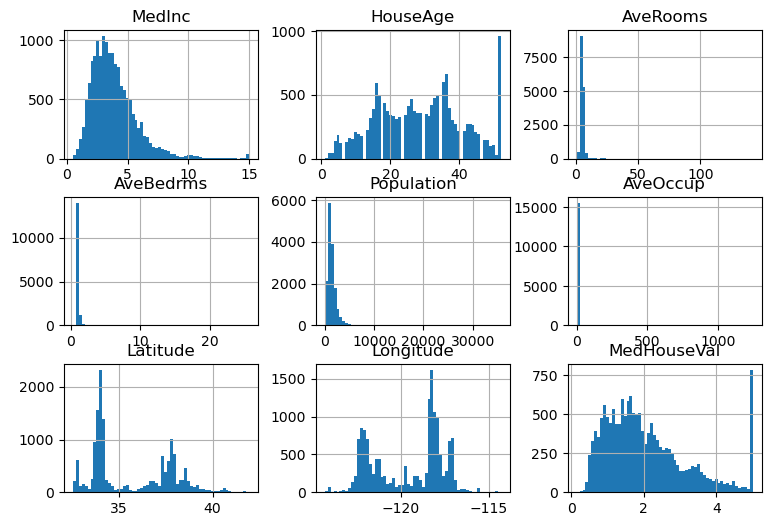

In [6]:
df.hist(bins=60, figsize=(9,6))
plt.show()

**Observation**: The Ave* and Population distributions are highly skewed.

**Task**: Regression models don't work well on highly skewed data, so we need to transform these.

**Strategy**: Doing power-transformation on `['AveRooms', 'AveBedrms', 'AveOccup', 'Population']` may help improve their correlation. We'll also do standardization on rest of the attributes.

In [7]:
df_a = df[['AveRooms', 'AveBedrms', 'AveOccup', 'Population']]
df_b = df[['MedInc', 'HouseAge']]
df_c = df[['Latitude', 'Longitude', 'MedHouseVal']]

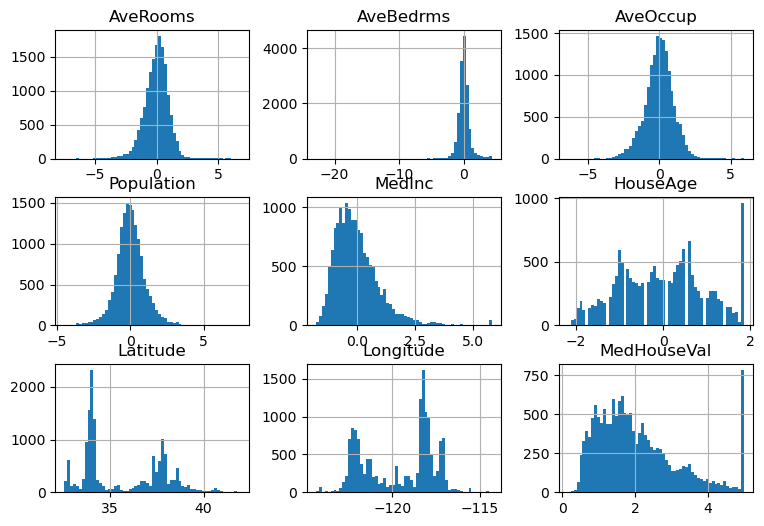

In [8]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
pt = PowerTransformer(method='yeo-johnson')
ss = StandardScaler()
df2 = pd.DataFrame(
    np.concatenate((pt.fit_transform(df_a),
                    ss.fit_transform(df_b),
                    df_c),
                    axis=1),
    columns=['AveRooms', 'AveBedrms', 'AveOccup', 'Population',
             'MedInc', 'HouseAge', 'Latitude', 'Longitude',
             'MedHouseVal'])

df2.hist(bins=60, figsize=(9,6))
plt.show()

**Observation**: With above, the first 6 attributes ('AveRooms', 'AveBedrms', 'AveOccup', 'Population', 'MedInc', 'HouseAge') have been transformed for use as predictors in the regression model. 

**Task**: Latitude and Longitude attributes need processing to engineer feature(s) that can serve as predictors in regression model.

**Strategy**: Plotting the median house values on coordinates map, we note that prices tend to be high close to two locations near the coast: 

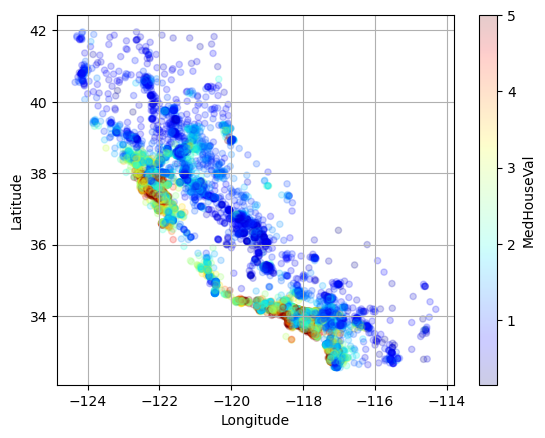

In [9]:
df.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, alpha=0.2, c="MedHouseVal", colormap='jet')
plt.show()